### Prepare environment

In [1]:
### Prepare environment
import os, getpass
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}:")
# set proxy
_set_env("PROXY_VALUE")
proxy = os.getenv("PROXY_VALUE")
for proxy_var in ['HTTP_PROXY', 'HTTPS_PROXY', 'http_proxy', 'https_proxy']:
    os.environ[proxy_var] = proxy
# GOOGLE API KEY
_set_env("GOOGLE_API_KEY")
print("proxy_value:", proxy)

proxy_value: http://localhost:7897


In [2]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"


### Human-in-the-loop
Human-inthe-loop(HIL) interactions are crucial for agentc systems. Waiting for human  input is a common HIL interaction pattern,
allowing the agent to ask the user clarifying questions and awati iput before processing.

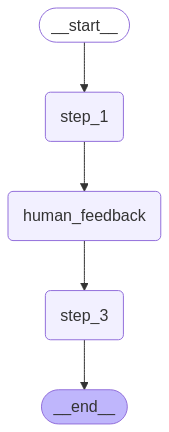

In [10]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display


class State(TypedDict):
    input: str
    user_feedback: str


def step_1(state):
    print("---Step 1---")
    pass


def human_feedback(state):
    print("---human_feedback---")
    feedback = interrupt("Please provide feedback:")
    return {"user_feedback": feedback}


def step_3(state):
    print("---Step 3---")
    pass


builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("human_feedback", human_feedback)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "human_feedback")
builder.add_edge("human_feedback", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

### Run until our breakpoint at `human_feedback`:

In [14]:
# Input
initial_input = {"input": "hello world"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph utility the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

---Step 1---
{'step_1': None}


---human_feedback---
{'__interrupt__': (Interrupt(value='Please provide feedback:', resumable=True, ns=['human_feedback:bc1b285c-fc85-dc8a-303c-084f453da73a']),)}




### Now, we can manually update our graph state with the user input

In [17]:
# Continue the graph execution
for event in graph.stream(
    Command(resume="go to step 3!"), thread, stream_mode="updates"
):
    print(event)
    print("\n")

---human_feedback---
{'human_feedback': {'user_feedback': 'go to step 3!'}}


---Step 3---
{'step_3': None}




In [18]:
### We can see our feedback was added to state
graph.get_state(thread).values

{'input': 'hello world', 'user_feedback': 'go to step 3!'}

In [19]:
graph.get_state(thread)

StateSnapshot(values={'input': 'hello world', 'user_feedback': 'go to step 3!'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f013bf9-762c-6b52-8003-49366891b2d2'}}, metadata={'source': 'loop', 'writes': {'step_3': None}, 'step': 3, 'parents': {}, 'thread_id': '1'}, created_at='2025-04-07T14:50:04.800079+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f013bf9-7629-6664-8002-5c8c27a3ea86'}}, tasks=())